# L2 – Multilayer perceptron

### PyTorch
1. [Installing PyTorch](https://pytorch.org/get-started/locally/)
2. [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
3. [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
4. [Useful examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
5. [Mnist example](https://habr.com/company/otus/blog/358096/)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset (possible, [this tutorial](https://habr.com/company/otus/blog/358096/) can help you).
4. Chek accuracy on train and validation sets (visualize resulted graph).

$$Q(W) = -\frac{1}{l}\sum_{y}\sum_{i}[y=i] \ln(\frac{e^{w_i x}}{\sum_j e^{w_j x}}) \\
\frac{dQ}{dw_i} = -\frac{1}{l}\sum_{y}\sum_{k}[y=k](\ln(\frac{e^{w_i x}}{\sum_je^{w_j x}}))_{w_i}^{'} = \\
= -\frac{1}{l}\sum_{y}\sum_{k}[y=k] ([k=i]ln(\frac{e^{w_k x}}{\sum_j e^{w_j x}}) + [k \neq i]ln(\frac{e^{w_k x}}{\sum_j e^{w_j x}}))_{w_i}^{'} = \\
= -\frac{1}{l}\sum_{y}\sum_{k}[y=k]([k=i]\frac{x\sum_j [i \neq j]e^{w_j x}}{\sum_j e^{w_j x}} - [k \neq i]\frac{xe^{w_i x}}{\sum_j e^{w_j x}}) = \\
= -\frac{1}{l}\sum_{y}\sum_{k}[y=k] ([k=i](x - \frac{x e^{w_i x}}{\sum_j e^{w_j x}}) - \dots) = \\
-\frac{1}{l}\sum_{y}\sum_{k}[y=k]([k = i]x - \frac{x e^{w_i x}}{\sum_j e^{w_j x}}) = \\
= -\frac{1}{l}\sum_{y} [y = i] x - \frac{x e^{w_i x}}{\sum_j e^{w_j x}}$$

We got $$\frac{dQ}{dW} = (\frac{dQ}{dw_1}, \dots, \frac{dQ}{dw_l})$$

In [115]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import utils
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

num_epochs = 20
num_classes = 10
batch_size = 3
learning_rate = 0.01

train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True,
                                           transform=transforms.ToTensor())

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False,
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

print(len(train_loader))

20000


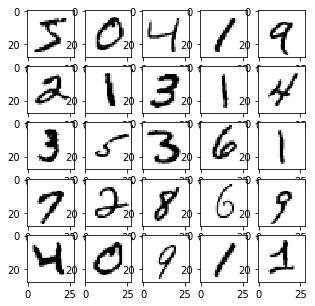

In [24]:
fig = plt.figure(figsize=(5, 5))
for i in range(25):
    fig.add_subplot(5, 5, i + 1)
    plt.imshow(train_dataset[i][0].reshape(28, 28), cmap='Greys')

plt.show()

In [116]:
class Net(nn.Module):
    def __init__(self, num_classes=10):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        out = x.view(-1, 28*28)
        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out

In [118]:
def train(epoch):
    for batch_idx, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 10000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    
def test():
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            test_loss += F.cross_entropy(outputs, labels, size_average=False).data.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
        test_correct_percent = 100 * test_correct / total
        err_log['test'].append((test_loss, test_correct_percent))
        
        train_loss = 0
        total = 0
        train_correct = 0
        for data, labels in train_loader:
            outputs = model(data)
            train_loss += F.cross_entropy(outputs, labels, size_average=False).data.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_correct_percent = 100 * train_correct / total
        err_log['train'].append((train_loss, train_correct_percent))
        
    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, test_correct, len(test_loader.dataset), test_correct_percent))
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset), train_correct_percent))

model = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
err_log = {'test': [], 'train': []}

for epoch in range(num_epochs):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.340933
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.007782

Test set:  Average loss: 2100.9796, Accuracy: 9352/10000 (94%)
Train set: Average loss: 12469.6976, Accuracy: 56222/60000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.048760
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.003413

Test set:  Average loss: 1422.5296, Accuracy: 9562/10000 (96%)
Train set: Average loss: 8027.0701, Accuracy: 57635/60000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.030352
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.002057

Test set:  Average loss: 1175.2153, Accuracy: 9637/10000 (96%)
Train set: Average loss: 6161.8437, Accuracy: 58158/60000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.020958
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.001555

Test set:  Average loss: 1054.4398, Accuracy: 9663/10000 (97%)
Train set: Average loss: 5144.4439, Accuracy: 58443/60000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.015525
Train Epoch: 4 [30000/60000 (50%)]	Loss: 0.000827

Test se

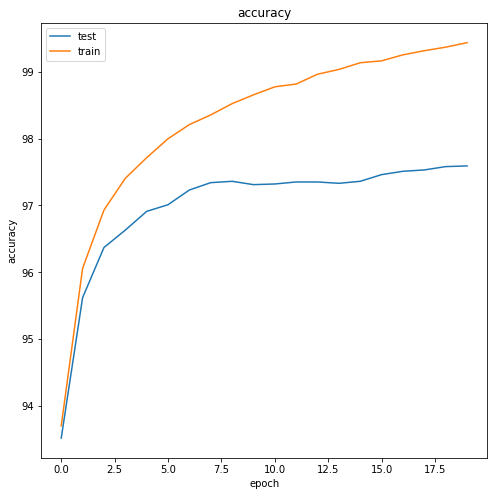

In [120]:
plt.figure(figsize=(8, 8))
keys = err_log.keys()
logs = {k:[z for z in zip(*err_log[k])] for k in keys}
epochs = {k:range(len(err_log[k])) for k in keys}

handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in keys])
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(handles=handlers)
plt.show()

Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

In [181]:
lamb1 = 0.3
lamb2 = 0.25

def new_train(epoch):
    for batch_idx, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        L1 = torch.norm(model.fc1.weight.data, 1) + torch.norm(model.fc2.weight.data, 1)
        L2 = torch.norm(model.fc1.weight.data ** 2, 2) + torch.norm(model.fc2.weight.data ** 2, 2)
        loss += lamb1 * L1 + lamb2 * L2
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

In [123]:
model = Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
err_log = {'test': [], 'train': []}

for epoch in range(num_epochs):
    new_train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 438.009125
Train Epoch: 0 [30000/60000 (50%)]	Loss: 591.758606

Test set:  Average loss: 2017.6454, Accuracy: 9377/10000 (94%)
Train set: Average loss: 12171.8840, Accuracy: 56341/60000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 652.124939
Train Epoch: 1 [30000/60000 (50%)]	Loss: 698.908630

Test set:  Average loss: 1370.8296, Accuracy: 9586/10000 (96%)
Train set: Average loss: 7850.9412, Accuracy: 57651/60000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 737.582520
Train Epoch: 2 [30000/60000 (50%)]	Loss: 770.791809

Test set:  Average loss: 1107.4937, Accuracy: 9656/10000 (97%)
Train set: Average loss: 5863.8209, Accuracy: 58244/60000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 799.880005
Train Epoch: 3 [30000/60000 (50%)]	Loss: 826.183838

Test set:  Average loss: 985.3279, Accuracy: 9692/10000 (97%)
Train set: Average loss: 4743.3365, Accuracy: 58537/60000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 849.927551
Train Epoch: 4 [30000/60000 (50%)]	Loss: 

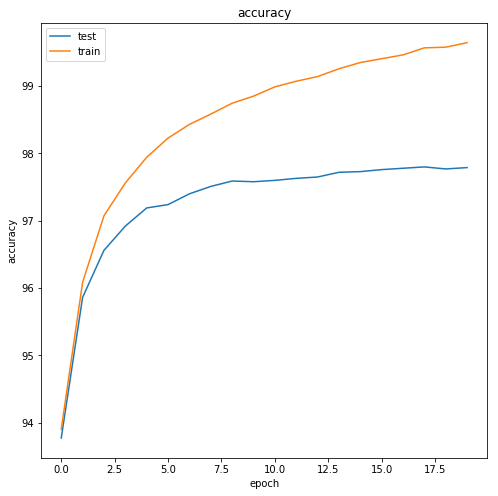

In [124]:
plt.figure(figsize=(8, 8))
keys = err_log.keys()
logs = {k:[z for z in zip(*err_log[k])] for k in keys}
epochs = {k:range(len(err_log[k])) for k in keys}

handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in keys])
plt.title('accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(handles=handlers)
plt.show()

In [156]:
print(model.fc1.weight.data.numpy())
res = model.fc1.weight.data.numpy()

[[ 0.000918   -0.02302439  0.03258257 ...  0.01694342  0.00335737
  -0.02885679]
 [ 0.03366725  0.03173702 -0.03565451 ... -0.02473956  0.03335077
  -0.0267927 ]
 [-0.01509742 -0.01416391 -0.02539912 ... -0.00121764  0.02833402
  -0.03456777]
 ...
 [ 0.03536786  0.00347028 -0.01309161 ... -0.0198259   0.01961109
   0.03338689]
 [ 0.03089959 -0.00550397 -0.00963132 ... -0.00165815 -0.03157117
   0.0091638 ]
 [ 0.03377848 -0.02816705  0.01358231 ... -0.00586758 -0.03408381
   0.03271187]]


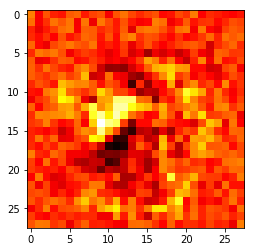

In [160]:
for i in range(100):
    plt.imshow(res[i].reshape(28, 28), cmap='hot')
plt.show()

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

We have:
$ 0 \ or \ 0 = 0 \\
  0 \ or \ 1 = 1 \\
  1 \ or \ 0 = 1 \\
  1 \ or \ 1 = 1 \\
$.
Let's take $w = (1.5, 1.5)$ and $b = -1$, so we get $\sigma(wx + b)$ which is equivalent to function $or$.

We have:
$ 0 \ and \ 0 = 0 \\
  0 \ and \ 1 = 0 \\
  1 \ and \ 0 = 0 \\
  1 \ and \ 1 = 1 \\
$.
Let's take $w = (1, 1)$ and $b = -1.5$, so we get what we wanted.

We have:
$ 0 \ xor \ 0 = 0 \\
 0 \ xor \ 1 = 1 \\
 1 \ xor \ 0 = 1 \\
 1 \ xor \ 1 = 0 \\
$.
We can get that $b > w_1 + w_2$, because with $x = (1, 1) \Rightarrow \sigma < 0$, similarly we can get that
$b < w_1$ and $b < w_2 \Rightarrow b < w_1 + w_2$, it is counterposition.

With $AND$ and $XOR$ we can construct $CNF$ and any boolean function can be represented with it, so we can approximate any boolean function.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [170]:
num_epochs = 20
num_classes = 10
batch_size = 100
learning_rate = 0.01

train_dataset = torchvision.datasets.MNIST(root='../../data/',
                                           train=True,
                                           transform=transforms.ToTensor())

test_dataset = torchvision.datasets.MNIST(root='../../data/',
                                          train=False,
                                          transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size = batch_size,
                                           shuffle=False)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [171]:
def train(epoch):
    for batch_idx, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(images), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    
def test():
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        total = 0
        for images, labels in test_loader:
            outputs = model(images)
            test_loss += F.cross_entropy(outputs, labels, size_average=False).data.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
        test_correct_percent = 100 * test_correct / total
        err_log['test'].append((test_loss, test_correct_percent))
        
        train_loss = 0
        total = 0
        train_correct = 0
        for data, labels in train_loader:
            outputs = model(data)
            train_loss += F.cross_entropy(outputs, labels, size_average=False).data.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        train_correct_percent = 100 * train_correct / total
        err_log['train'].append((train_loss, train_correct_percent))
        
    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, test_correct, len(test_loader.dataset), test_correct_percent))
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset), train_correct_percent))

In [172]:
class SigNet(nn.Module):
    def __init__(self, numclasses = 10):
        super(SigNet, self).__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        out = x.view(-1, 28*28)
        out = torch.sigmoid(self.fc1(out))
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1)
        return out

In [173]:
model = SigNet(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
err_log = {'test': [], 'train': []}

for epoch in range(num_epochs):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.345602
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.269514
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.249112
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.233383
Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.172514
Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.162417

Test set:  Average loss: 21081.0778, Accuracy: 5555/10000 (56%)
Train set: Average loss: 126723.2605, Accuracy: 33009/60000 (55%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.090956
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.060119
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.042205
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.015663
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.867934
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.863751

Test set:  Average loss: 17646.7657, Accuracy: 6385/10000 (64%)
Train set: Average loss: 106459.7131, Accuracy: 37757/60000 (63%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.730751
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.692585
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.703579
T

Train Epoch: 19 [20000/60000 (33%)]	Loss: 0.501809
Train Epoch: 19 [30000/60000 (50%)]	Loss: 0.439837
Train Epoch: 19 [40000/60000 (67%)]	Loss: 0.349277
Train Epoch: 19 [50000/60000 (83%)]	Loss: 0.425122

Test set:  Average loss: 3722.3191, Accuracy: 9005/10000 (90%)
Train set: Average loss: 23265.4991, Accuracy: 53670/60000 (89%)



# Layer 3

In [174]:
class Layer3Net(nn.Module):
    def __init__(self, num_classes = 10):
        super(Layer3Net, self).__init__()
        self.fc1 = nn.Linear(784, 450)
        self.fc2 = nn.Linear(450, 100)
        self.fc3 = nn.Linear(100, 10)

    def forward(self, x):
        out = x.view(-1, 28*28)
        out = F.leaky_relu(self.fc1(out))
        out = F.leaky_relu(self.fc2(out))
        out = F.leaky_relu(self.fc3(out))
        out = F.log_softmax(out, dim=1)
        return out

In [175]:
model = Layer3Net(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
err_log = {'test': [], 'train': []}

for epoch in range(num_epochs):
    train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.304652
Train Epoch: 0 [10000/60000 (17%)]	Loss: 2.284599
Train Epoch: 0 [20000/60000 (33%)]	Loss: 2.257490
Train Epoch: 0 [30000/60000 (50%)]	Loss: 2.234962
Train Epoch: 0 [40000/60000 (67%)]	Loss: 2.158082
Train Epoch: 0 [50000/60000 (83%)]	Loss: 2.122679

Test set:  Average loss: 19510.5296, Accuracy: 4792/10000 (48%)
Train set: Average loss: 118002.2211, Accuracy: 27970/60000 (47%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.992685
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.794143
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.717232
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.694570
Train Epoch: 1 [40000/60000 (67%)]	Loss: 1.484493
Train Epoch: 1 [50000/60000 (83%)]	Loss: 1.379701

Test set:  Average loss: 10902.8277, Accuracy: 7288/10000 (73%)
Train set: Average loss: 67609.8969, Accuracy: 43071/60000 (72%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.119889
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.001402
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.969858
Tr

Train Epoch: 19 [20000/60000 (33%)]	Loss: 0.199145
Train Epoch: 19 [30000/60000 (50%)]	Loss: 0.188472
Train Epoch: 19 [40000/60000 (67%)]	Loss: 0.148533
Train Epoch: 19 [50000/60000 (83%)]	Loss: 0.166435

Test set:  Average loss: 1806.0308, Accuracy: 9470/10000 (95%)
Train set: Average loss: 10703.4088, Accuracy: 56976/60000 (95%)



# Layer Hard

In [191]:
class LayerHardNet(nn.Module):
    def __init__(self, num_classes = 10):
        super(LayerHardNet, self).__init__()
        self.fc1 = nn.Linear(784, 350)
        self.fc2 = nn.Linear(350, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 10)

    def forward(self, x):
        out = x.view(-1, 28*28)
        out = torch.sigmoid(self.fc1(out))
        out = F.leaky_relu(self.fc2(out))
        out = F.relu(self.fc3(out))
        out = self.fc4(out)
        out = F.log_softmax(out, dim=1)
        return out

In [194]:
lamb1 = 0.5
lamb2 = 0.5
num_epochs = 40
learning_rate = 0.001
model = LayerHardNet(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
err_log = {'test': [], 'train': []}

for epoch in range(num_epochs):
    new_train(epoch)
    test()

Train Epoch: 0 [0/60000 (0%)]	Loss: 3387.953125
Train Epoch: 0 [10000/60000 (17%)]	Loss: 5276.942871
Train Epoch: 0 [20000/60000 (33%)]	Loss: 5935.163574
Train Epoch: 0 [30000/60000 (50%)]	Loss: 6334.715332
Train Epoch: 0 [40000/60000 (67%)]	Loss: 6704.724609
Train Epoch: 0 [50000/60000 (83%)]	Loss: 7054.235840

Test set:  Average loss: 2449.8822, Accuracy: 9245/10000 (92%)
Train set: Average loss: 15136.6137, Accuracy: 55350/60000 (92%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 7372.561523
Train Epoch: 1 [10000/60000 (17%)]	Loss: 7576.484863
Train Epoch: 1 [20000/60000 (33%)]	Loss: 7858.058105
Train Epoch: 1 [30000/60000 (50%)]	Loss: 8039.893066
Train Epoch: 1 [40000/60000 (67%)]	Loss: 8269.905273
Train Epoch: 1 [50000/60000 (83%)]	Loss: 8542.731445

Test set:  Average loss: 1687.9529, Accuracy: 9500/10000 (95%)
Train set: Average loss: 9900.2324, Accuracy: 56970/60000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 8745.536133
Train Epoch: 2 [10000/60000 (17%)]	Loss: 8896.181641
Train Epoch: 2

Train Epoch: 18 [30000/60000 (50%)]	Loss: 18476.443359
Train Epoch: 18 [40000/60000 (67%)]	Loss: 18522.519531
Train Epoch: 18 [50000/60000 (83%)]	Loss: 18595.525391

Test set:  Average loss: 1129.8682, Accuracy: 9784/10000 (98%)
Train set: Average loss: 665.9139, Accuracy: 59779/60000 (100%)

Train Epoch: 19 [0/60000 (0%)]	Loss: 18642.660156
Train Epoch: 19 [10000/60000 (17%)]	Loss: 18694.412109
Train Epoch: 19 [20000/60000 (33%)]	Loss: 18738.814453
Train Epoch: 19 [30000/60000 (50%)]	Loss: 18776.000000
Train Epoch: 19 [40000/60000 (67%)]	Loss: 18816.863281
Train Epoch: 19 [50000/60000 (83%)]	Loss: 18885.335938

Test set:  Average loss: 1334.7393, Accuracy: 9740/10000 (97%)
Train set: Average loss: 1320.8851, Accuracy: 59548/60000 (99%)

Train Epoch: 20 [0/60000 (0%)]	Loss: 18948.724609
Train Epoch: 20 [10000/60000 (17%)]	Loss: 18993.009766
Train Epoch: 20 [20000/60000 (33%)]	Loss: 19016.396484
Train Epoch: 20 [30000/60000 (50%)]	Loss: 19060.236328
Train Epoch: 20 [40000/60000 (67%)]	L

Train Epoch: 36 [40000/60000 (67%)]	Loss: 23066.996094
Train Epoch: 36 [50000/60000 (83%)]	Loss: 23112.759766

Test set:  Average loss: 1309.3976, Accuracy: 9799/10000 (98%)
Train set: Average loss: 259.7904, Accuracy: 59903/60000 (100%)

Train Epoch: 37 [0/60000 (0%)]	Loss: 23150.943359
Train Epoch: 37 [10000/60000 (17%)]	Loss: 23179.099609
Train Epoch: 37 [20000/60000 (33%)]	Loss: 23197.798828
Train Epoch: 37 [30000/60000 (50%)]	Loss: 23223.695312
Train Epoch: 37 [40000/60000 (67%)]	Loss: 23267.138672
Train Epoch: 37 [50000/60000 (83%)]	Loss: 23325.787109

Test set:  Average loss: 1265.0915, Accuracy: 9800/10000 (98%)
Train set: Average loss: 528.6585, Accuracy: 59841/60000 (100%)

Train Epoch: 38 [0/60000 (0%)]	Loss: 23392.228516
Train Epoch: 38 [10000/60000 (17%)]	Loss: 23428.716797
Train Epoch: 38 [20000/60000 (33%)]	Loss: 23441.908203
Train Epoch: 38 [30000/60000 (50%)]	Loss: 23459.800781
Train Epoch: 38 [40000/60000 (67%)]	Loss: 23475.779297
Train Epoch: 38 [50000/60000 (83%)]	L

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.